# LiveRamp TERM Presentation - BART Analysis

Coded by Joshua Chan - October 2019

analysis to be done:
- histogram of times in which the traffic starts to pick up, per day
- histogram of days of the week based on traffic
- histogram of the influence the holidays play 


- separate the different stations by county
- measure how much traffic each region has increased and by how much time
- discuss the implications of each increase, and some possible solutions on how Bay Area traffic can improve by doing some reading

#####

BART's policy on Weekend trains has always been baffling. They currently run a different set of trains on Sundays compared to the rest of the week. 

Should BART continue to keep separated hours on Sundays compared to other days of the week? Or should BART shut down Saturdays compared to the other days? 

### Outline
1. Set up the context of the data set (maybe one screenshot of what it looks like)
2. Show some preliminarily interesting graphs to act as the "hook"
3. Experiment Part 1:
    - First Hypothesis: If we showcase the drop off in Sunday rides because of the transfers, we can justify having full train service for the entire week.
    - i.e. {Saturday w/only transfers - Sunday w/only transfers} - {Saturday w/no transfers - Sunday w/ no transfers}
    - The result ends up being...about 0, which indicates that people don't really care about the fact that you have to transfer? If people don't really care, then why maintain run a full track schedule over Saturday then?
    - What are some of the differences between riding on Sunday then Saturday aside from Train Schedule?
4. Experiment Part 2:
    - Second Hypothesis: If 

## Setting Up

In [242]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import datetime
import warnings
import re

sns.set()
sns.axes_style("darkgrid")
warnings.filterwarnings("ignore", category = FutureWarning)
sns.set_context('talk') # Makes the axes labels larger

In [243]:
# Add the relevant data sets
bart_11 = pd.read_csv('bart_2011.csv', header = None) # 2011 Bart Data
bart_12 = pd.read_csv('bart_2012.csv', header = None)
bart_13 = pd.read_csv('bart_2013.csv', header = None)
bart_14 = pd.read_csv('bart_2014.csv', header = None)
bart_15 = pd.read_csv('bart_2015.csv', header = None)
bart_16 = pd.read_csv('bart_2016.csv', header = None)
bart_17 = pd.read_csv('bart_2017.csv', header = None)
bart_18 = pd.read_csv('bart_2018.csv', header = None)
station = pd.read_csv('station_info.csv') # Information about what abbreviations are which stations

In [244]:
bart_districts = {
    "North Alameda": ['RICH', 'DELN', 'PLZA','NBRK','DBRK','ASHB','ROCK'],
    "East Alameda": ['CAST', 'WDUB', 'DUBL'],
    "Central Alameda": ["MCAR", '12TH', '19TH', 'WOAK', 'LAKE','FTVL','COLS', 'OAKL', 'SANL','BAYF'],
    "South Alameda": ['HAYW','SHAY','UCTY','FRMT', 'WARM', 'WSPR'],
    "West Contra Costa": ['ORIN', 'LAFY', 'WCRK', 'PHIL'],
    "East Contra Costa": ['ANTC', 'PCTR', 'PITT', 'NCON', 'CONC', 'ANTI'],
    "South San Francisco": ['MLBR', 'SFIA', 'SBRN', 'SSAN', 'COLM', 'DALY'],
    "San Francisco": ['BALB', 'GLEN', '24TH', '16TH', 'CIVC','POWL', 'MONT', 'EMBR'],
}

# Converts the above districts into a {"RICH":"North Alameda"} dictionary format
bart_district = {}
for key, value in bart_districts.items():
    for i in value:
        bart_district[i] = key

In [245]:
# Add the new stations into the station dataframe
station = station.append({'Abbreviation':'WSPR', "Description": None, "Location":None, "Name":"Warm Springs       "}, ignore_index = True)
station = station.append({'Abbreviation':'ANTI', "Description": None, "Location":None, "Name":"Antioch       "}, ignore_index = True)

In [246]:
# adds month, day, day_of_week onto the dataframes
def expand_date(df):
    df.columns = ['date', 'hour', 'start', 'destination', 'throughput']
    date = np.array(df['date'])
    time = np.apply_along_axis(lambda x: pd.to_datetime(x), 0, date)
    day = np.apply_along_axis(lambda x: pd.to_datetime(x).day, 0, date)
    month = np.apply_along_axis(lambda x: pd.to_datetime(x).month, 0, date)
    day_of_week = np.apply_along_axis(lambda x: pd.to_datetime(x).weekday, 0, date)
    df['date'] = time
    df['month'] = month
    df['day'] = day
    df['day_of_week'] = day_of_week
    return df[['date','month', 'day', 'hour','day_of_week', 'start', 'destination', 'throughput']]

In [247]:
# apply the function on all of the datasets
bart_11 = expand_date(bart_11);
bart_12 = expand_date(bart_12);
bart_13 = expand_date(bart_13);
bart_14 = expand_date(bart_14);
bart_15 = expand_date(bart_15);
bart_16 = expand_date(bart_16);
bart_17 = expand_date(bart_17);
bart_18 = expand_date(bart_18);

In [248]:
weekday_11 = bart_11[(bart_11['day_of_week'] != 5) & (bart_11['day_of_week'] != 6)]
weekday_12 = bart_12[(bart_12['day_of_week'] != 5) & (bart_12['day_of_week'] != 6)]
weekday_13 = bart_13[(bart_13['day_of_week'] != 5) & (bart_13['day_of_week'] != 6)]
weekday_14 = bart_14[(bart_14['day_of_week'] != 5) & (bart_14['day_of_week'] != 6)]
weekday_15 = bart_15[(bart_15['day_of_week'] != 5) & (bart_15['day_of_week'] != 6)]
weekday_16 = bart_16[(bart_16['day_of_week'] != 5) & (bart_16['day_of_week'] != 6)]
weekday_17 = bart_17[(bart_17['day_of_week'] != 5) & (bart_17['day_of_week'] != 6)]
weekday_18 = bart_18[(bart_18['day_of_week'] != 5) & (bart_18['day_of_week'] != 6)]

In [249]:
%%time
num_weekday = 260
avg_weekday_dict = {}
year = 2011
for i in [weekday_11, weekday_12, weekday_13, weekday_14, weekday_15, weekday_16, weekday_17, weekday_18]:
    avg_weekday_dict[year] = i.groupby('date').sum()['throughput'].sum()/num_weekday
    year += 1

Wall time: 15.7 s


In [250]:
avg_weekday = pd.DataFrame.from_dict(avg_weekday_dict, orient = 'index')
avg_weekday

,0
2011,348147.461538
2012,374562.719231
2013,378687.430769
2014,404353.319231
2015,420345.511538
2016,424340.311538
2017,408282.796154
2018,403912.503846


Text(0.5, 0, 'Year')

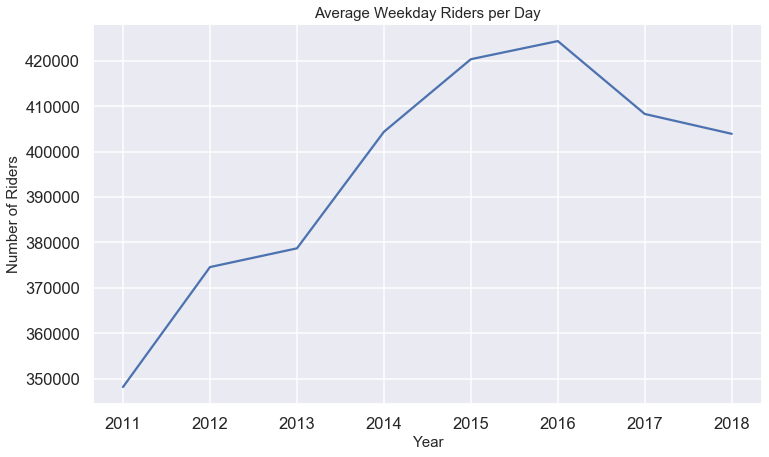

In [251]:
fig, axs = plt.subplots(figsize = (12, 7))
sns.lineplot(y = avg_weekday[0], x = avg_weekday.index, palette=("Blues"))
plt.title('Average Weekday Riders per Day', fontsize = 15)
plt.ylabel('Number of Riders', fontsize=15)
plt.xlabel("Year", fontsize=15)

In [252]:
weekday_11.head()

,date,month,day,hour,day_of_week,start,destination,throughput
38377,2011-01-03,1,3,0,0,12TH,24TH,1
38378,2011-01-03,1,3,0,0,12TH,ASHB,3
38379,2011-01-03,1,3,0,0,12TH,BAYF,1
38380,2011-01-03,1,3,0,0,12TH,CIVC,1
38381,2011-01-03,1,3,0,0,12TH,CONC,1


In [253]:
%%time
year = 2011
num_weekday = 260
morning_weekday = {}
afternoon_weekday = {}
off_prime_weekday = {}
off_peak_weekday = {}
for i in [weekday_11, weekday_12, weekday_13, weekday_14, weekday_15, weekday_16, weekday_17, weekday_18]:
    morning = i[(i['hour'] == 7) | (i['hour'] == 8) | (i['hour'] == 9)]
    afternoon = i[(i['hour'] == 16) | (i['hour'] == 17) | (i['hour'] == 18)]
    off_peak = i[(i['hour'] != 16)&(i['hour']!=17)&(i['hour']!=18)&(i['hour']!=7)&(i['hour']!=8)&(i['hour']!=9)]

    morning_weekday[year] = morning['throughput'].sum()/i['throughput'].sum()
    afternoon_weekday[year] = afternoon['throughput'].sum()/i['throughput'].sum()
    off_peak_weekday[year] = off_peak['throughput'].sum()/i['throughput'].sum()
    year += 1

Wall time: 16.5 s


In [254]:
morning_weekday = pd.DataFrame.from_dict(morning_weekday, orient = 'index')
afternoon_weekday = pd.DataFrame.from_dict(afternoon_weekday, orient = 'index')
off_peak_weekday = pd.DataFrame.from_dict(off_peak_weekday, orient = 'index')

In [255]:
off_peak_weekday

,0
2011,0.440086
2012,0.442414
2013,0.440554
2014,0.438560
2015,0.434112
2016,0.426213
2017,0.419448
2018,0.411107


Text(0.5, 0, 'Year')

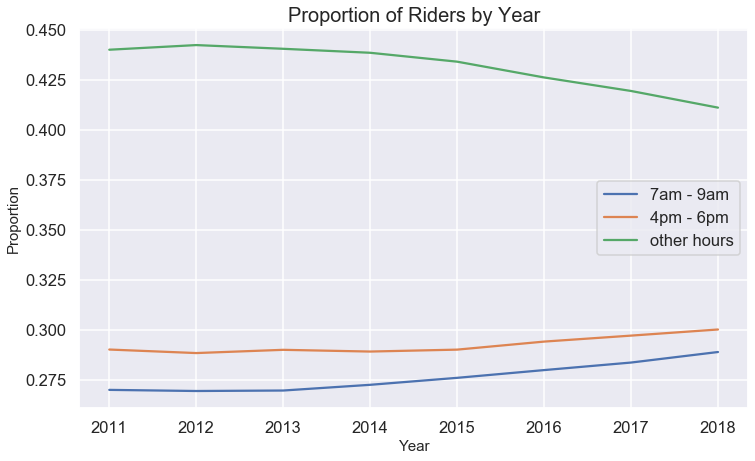

In [256]:
fig, axs = plt.subplots(figsize = (12, 7))
plt.title('Proportion of Riders by Year', fontsize = 20)
sns.lineplot(y = morning_weekday[0],x = morning_weekday.index, label = '7am - 9am')
sns.lineplot(y = afternoon_weekday[0],x = afternoon_weekday.index, label = '4pm - 6pm')
sns.lineplot(y = off_peak_weekday[0],x = off_peak_weekday.index, label = 'other hours')
plt.legend()
plt.ylabel('Proportion', fontsize=15)
plt.xlabel("Year", fontsize=15)

Text(0.5, 0, 'Time of Day')

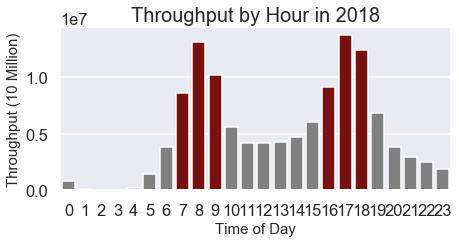

In [257]:
fig, axs = plt.subplots(figsize = (7, 3))
plt.title('Throughput by Hour in 2018', fontsize = 20)
clrs = ['gray' if (x not in [7, 8, 9, 16, 17, 18]) else 'darkred' for x in bart_18.groupby('hour').sum().index]
sns.barplot(y = bart_18.groupby('hour').sum()['throughput'], x = bart_18.groupby('hour').sum().index, palette=(clrs))

plt.ylabel('Throughput (10 Million)', fontsize=15)
plt.xlabel("Time of Day", fontsize=15)

In [258]:
# also use august bc it has no holidays, so the data is extremely consistent 
aug_17 = bart_17[bart_17['month'] == 8]
aug_18 = bart_18[bart_18['month'] == 8]

# only get the first 4 weeks of august to make sure each day of the week is represented exactly times
aug_17 = aug_17[aug_17['day'] <= 28]
aug_18 = aug_18[aug_18['day'] <= 28]

In [259]:
plots = bart_18.groupby('day_of_week').sum()

Text(0.5, 0, 'Day of the Week')

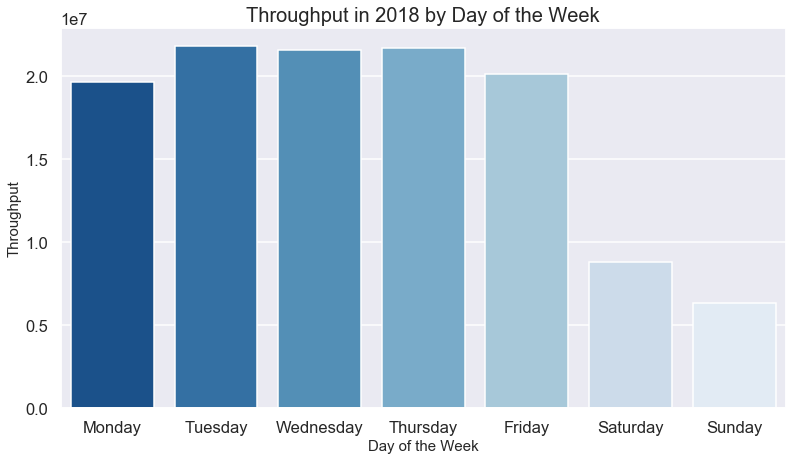

In [275]:
fig, axs = plt.subplots(figsize = (13, 7))
plt.title('Throughput in 2018 by Day of the Week', fontsize = 20)
sns.barplot(data = plots, x = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], y='throughput', palette = 'Blues_r')
plt.ylabel('Throughput', fontsize=15)
plt.xlabel("Day of the Week", fontsize=15)

In [19]:
aug_18.groupby('day_of_week').sum()[['throughput']].reset_index()

,day_of_week,throughput
0,0,1625602
1,1,1721174
2,2,1720498
3,3,1697772
4,4,1623642
5,5,639215
6,6,469205


## Sunday vs Rest of the Week Analysis

In [20]:
aug_18.head()

,date,month,day,hour,day_of_week,start,destination,throughput
5871747,2018-08-01,8,1,0,2,12TH,12TH,1
5871748,2018-08-01,8,1,0,2,12TH,24TH,1
5871749,2018-08-01,8,1,0,2,12TH,ANTI,1
5871750,2018-08-01,8,1,0,2,12TH,BAYF,3
5871751,2018-08-01,8,1,0,2,12TH,DALY,2


take only the trips that require a single train on sundays, and compare the amount of throughput. Do a permutation test accordingly. So itll look like:

no_transfer = only trips, of all days, that take no transfers to get to where you want. then segregate it by Weekdays, Saturday, Sunday;
- no_transfer_week
- no_transfer_sat
- no_transfer_sun
do a groupby on the day of the week.sum()

yes_transfer = all trips that do require a transfer (on sunday) then segregate it again
- transfer_week
- transfer_sat
- transfer_sun




In [21]:
# Train stations that require no transfers, assuming the Start and Destination both belong to the same line
yellow_line = [
    'MLBR', 'SFIA', 'SBRN', 'SSAN', 'COLM', 'DALY','BALB', 'GLEN', '24TH', '16TH', 'CIVC','POWL', 'MONT', 'EMBR',\
    'ANTC', 'PCTR', 'PITT', 'NCON', 'CONC', 'ANTI','ORIN', 'LAFY', 'WCRK', 'PHIL',\
    'ROCK', 'MCAR', '19TH', '12TH'
]
orange_line = [
    'HAYW','SHAY','UCTY','FRMT', 'WARM', 'WSPR','RICH', 'DELN', 'PLZA','NBRK','DBRK','ASHB',\
    "MCAR", '12TH', '19TH','LAKE','FTVL','COLS', 'SANL','BAYF'
]
blue_line = [
    'CAST', 'WDUB', 'DUBL', "MCAR", '12TH', '19TH', 'LAKE','FTVL','COLS','SANL','BAYF'
]

In [22]:
def get_no_transfers(df):
    """
    Takes df and adds a new column that indicates whether or not the trip requires a train transfer,
    assuming it runs on a Sunday train schedule
    """
    yellow = df[['start', 'destination']].isin(yellow_line) & df[['start', 'destination']].isin(yellow_line)
    yellow['yellow'] = yellow['start'] & yellow['destination']

    orange = df[['start', 'destination']].isin(orange_line) & df[['start', 'destination']].isin(orange_line)
    orange['orange'] = orange['start'] & orange['destination']

    blue = df[['start', 'destination']].isin(blue_line) & df[['start', 'destination']].isin(blue_line)
    blue['blue'] = blue['start'] & blue['destination']

    condition = pd.concat([yellow['yellow'], orange['orange'], blue['blue']], axis = 1)
    condition['no_transfer'] = condition['yellow'] | condition['orange'] | condition['blue']
    df['no_transfer'] = condition['no_transfer']
    return df

In [47]:
aug_17 = get_no_transfers(aug_17)
aug_18 = get_no_transfers(aug_18)

In [89]:
tr_18 = get_no_transfers(bart_18)

## More experimental Design
write a permutation test that showcases how the proportion of rides on sundays for transfers actually increases instead of decreases, alpha = 0.05.

This means that people seem to be undeterred by the fact that they have to transfer, otherwise we should be seeing a decrease in the number of rides that require a transfer. Transferring means that they have to physically change stations and denotes a longer commute time.

But we are able to show that the kinds of riders who ride on Saturday are similar to the kinds of people who ride on Sunday as opposed to the weekdays, then it can be another reason why changing Saturday schedules to sunday schedules are appropriate.

We can do this by showcasing the times in which people make their rides. since you had classified before hand the regions in which people ride from, then we can do a permutation test to see the number of rides that occur.

In [90]:
t_18 = tr_18.copy()
t_18 = t_18[['day_of_week','start', 'destination', 'throughput', 'no_transfer']]

# Permutation Test on Transfers

### Observed Statistic

In [91]:
no_transfer_18 = t_18[t_18['no_transfer'] == True].drop(columns = ['no_transfer'])
no_transfer_18 = no_transfer_18.groupby('day_of_week').sum()[['throughput']]
no_transfer_18['throughput'] = no_transfer_18['throughput']/no_transfer_18['throughput'].sum()
no_transfer_2018_sunday = no_transfer_18.iloc[6]['throughput']
no_transfer_2018_sunday
# interpretation: of all the rides that do not require a transfer on a sunday (and not on any other day), 
# Sunday accounts for 5.20% of them.

0.05207668451600121

In [92]:
transfer_18 = t_18[t_18['no_transfer'] == False].drop(columns = ['no_transfer'])
transfer_18 = transfer_18.groupby('day_of_week').sum()[['throughput']]
transfer_18['throughput'] = transfer_18['throughput']/transfer_18['throughput'].sum()
transfer_2018_sunday = transfer_18.iloc[6]['throughput']
transfer_2018_sunday
# interpretation: of all the rides that require a transfer on a sunday (and not on any other day), 
# Sunday accounts for 5.45% of them.

0.05450430798863394

In [60]:
# observed value:
no_transfer_2018_sunday - transfer_2018_sunday

-0.0024276234726327284

### Calculate one test statistic

In [112]:
def transfer_permutation_test(t_18):
    shuffle = t_18['no_transfer'].sample(replace = False, frac = 1).reset_index(drop = True)
    shuffled_original = t_18.assign(**{'no_transfer': shuffle})
    
    no_transfer_18 = shuffled_original[shuffled_original['no_transfer'] == True]#.drop(columns = ['no_transfer'])
    no_transfer_18 = no_transfer_18.groupby('day_of_week').sum()[['throughput']]
    no_transfer_18['throughput'] = no_transfer_18['throughput']/no_transfer_18['throughput'].sum()
    #print(no_transfer_18['throughput'])
    no_transfer_2018_sunday = no_transfer_18.iloc[6]['throughput']

    transfer_18 = shuffled_original[shuffled_original['no_transfer'] == False]#.drop(columns = ['no_transfer'])
    transfer_18 = transfer_18.groupby('day_of_week').sum()[['throughput']]
    transfer_18['throughput'] = transfer_18['throughput']/transfer_18['throughput'].sum()
    transfer_2018_sunday = transfer_18.iloc[6]['throughput']
    return no_transfer_2018_sunday - transfer_2018_sunday

Wall time: 0 ns


In [113]:
transfer_permutation_test(t_18)

0.00011577792781748697

### Avoid running this cell b/c 20 minute simulation time

In [118]:
# %%time
# shuffle = []
# for i in range(500):
#     shuffle.append(transfer_permutation_test(t_18))

Wall time: 20min 1s


Text(0.5, 0, 'Difference Between Transfer & Non-Transfer')

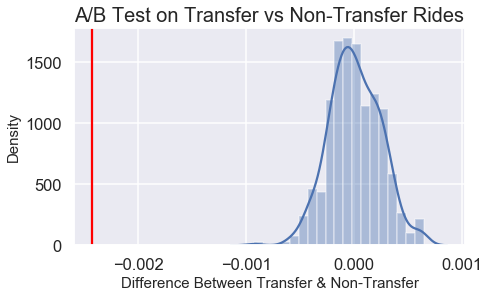

In [126]:
fig, axs = plt.subplots(figsize = (7, 4))
plt.title('A/B Test on Transfer vs Non-Transfer Rides', fontsize = 20)
sns.distplot(shuffle, hist = True)
plt.axvline(-0.0024276234726327284, 0, 2, color = 'red')
plt.ylabel('Density', fontsize=15)
plt.xlabel("Difference Between Transfer & Non-Transfer", fontsize=15)

In [129]:
np.count_nonzero(shuffle > no_transfer_2018_sunday - transfer_2018_sunday)

500

## Difference in Region A/B Test

In [221]:
bart_region = bart_18.copy()
bart_region = bart_region[['day_of_week', 'start', 'throughput']]
bart_region.head()

,day_of_week,start,throughput
0,0,12TH,3
1,0,12TH,1
2,0,12TH,1
3,0,12TH,3
4,0,12TH,2


In [292]:
sun_18 = bart_region[bart_region['day_of_week'] == 6].groupby('start').sum()[['throughput']]
sat_18 = bart_region[bart_region['day_of_week'] == 5].groupby('start').sum()[['throughput']]
weekday_18 = bart_region[(bart_region['day_of_week'] != 5) & (bart_region['day_of_week'] != 6)].groupby('start').sum()[['throughput']]
district_lst = []

for i in sun_18.iterrows():
    district_lst.append(bart_district[i[0]])
sun_18['district'] = district_lst
sat_18['district'] = district_lst
weekday_18['district'] = district_lst
    
sat_18 = sat_18.reset_index().groupby('district').sum()[['throughput']]
sat_18['throughput'] = sat_18['throughput']/sat_18['throughput'].sum()

sun_18 = sun_18.reset_index().groupby('district').sum()[['throughput']]
sun_18['throughput'] = sun_18['throughput']/sun_18['throughput'].sum()

weekday_18 = weekday_18.reset_index().groupby('district').sum()[['throughput']]
weekday_18['throughput'] = weekday_18['throughput']/weekday_18['throughput'].sum()
sun_sat = (abs(sun_18 - sat_18)).sum()
sun_weekday = (abs(sun_18 - weekday_18)).sum()

In [276]:
def sunday_difference_null_hypothesis(bart_region):
    shuffle = bart_region['day_of_week'].sample(replace = False, frac = 1).reset_index(drop = True)
    bart_region = bart_region.assign(**{'day_of_week': shuffle})
    sun_18 = bart_region[bart_region['day_of_week'] == 6].groupby('start').sum()[['throughput']]
    sat_18 = bart_region[bart_region['day_of_week'] == 5].groupby('start').sum()[['throughput']]
    weekday_18 = bart_region[(bart_region['day_of_week'] != 5) & (bart_region['day_of_week'] != 6)].groupby('start').sum()[['throughput']]
    district_lst = []

    for i in sun_18.iterrows():
        district_lst.append(bart_district[i[0]])
    sun_18['district'] = district_lst
    sat_18['district'] = district_lst
    weekday_18['district'] = district_lst
    
    sat_18 = sat_18.reset_index().groupby('district').sum()[['throughput']]
    sat_18['throughput'] = sat_18['throughput']/sat_18['throughput'].sum()

    sun_18 = sun_18.reset_index().groupby('district').sum()[['throughput']]
    sun_18['throughput'] = sun_18['throughput']/sun_18['throughput'].sum()

    weekday_18 = weekday_18.reset_index().groupby('district').sum()[['throughput']]
    weekday_18['throughput'] = weekday_18['throughput']/weekday_18['throughput'].sum()
    sun_sat = (abs(sun_18 - sat_18)).sum()
    sun_weekday = (abs(sun_18 - weekday_18)).sum()
    return sun_sat - sun_weekday

In [285]:
sunday_difference_null_hypothesis(bart_region)

throughput    0.000385
dtype: float64

### Don't run this bc it takes 24 minutes

In [232]:
# %%time
# sunday_hypo = []
# for i in range(500):
#     sunday_hypo.append(sunday_difference_null_hypothesis(bart_region))

Wall time: 24min 21s


Text(0.5, 0, 'Difference Between Sun/Sat vs Sun/Weekday')

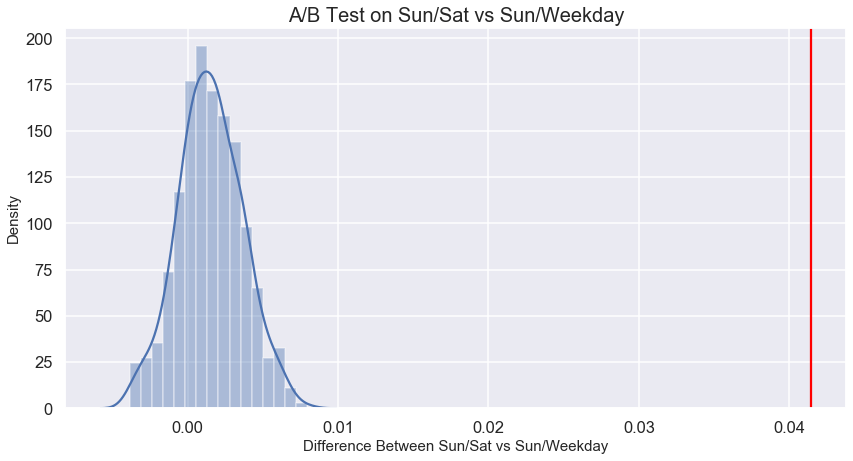

In [234]:
fig, axs = plt.subplots(figsize = (14, 7))
plt.title('A/B Test on Sun/Sat vs Sun/Weekday', fontsize = 20)
sns.distplot(sunday_hypo, hist = True)
plt.axvline(0.041435, 0, 2, color = 'red')
plt.ylabel('Density', fontsize=15)
plt.xlabel("Difference Between Sun/Sat vs Sun/Weekday", fontsize=15)

In [295]:
weekends = sun_18 - sat_18
weekends

,throughput
district,
Central Alameda,-0.000138
East Alameda,-0.000032
East Contra Costa,0.000982
North Alameda,0.000331
San Francisco,-0.002058
South Alameda,0.000413
South San Francisco,0.000900
West Contra Costa,-0.000397


In [296]:
weekend_weekday = sun_18 - weekday_18
weekend_weekday

,throughput
district,
Central Alameda,-0.000908
East Alameda,-0.000759
East Contra Costa,0.000643
North Alameda,0.000244
San Francisco,-0.000488
South Alameda,0.000151
South San Francisco,0.001249
West Contra Costa,-0.000132


In [287]:
sun_sat = (abs(sun_18 - sat_18)).sum()

In [288]:
sun_weekday = (abs(sun_18 - weekday_18)).sum()

In [289]:
sun_sat

throughput    0.005251
dtype: float64

In [290]:
sun_weekday

throughput    0.004574
dtype: float64

Text(0.5, 0, 'Difference in Throughput Proportion')

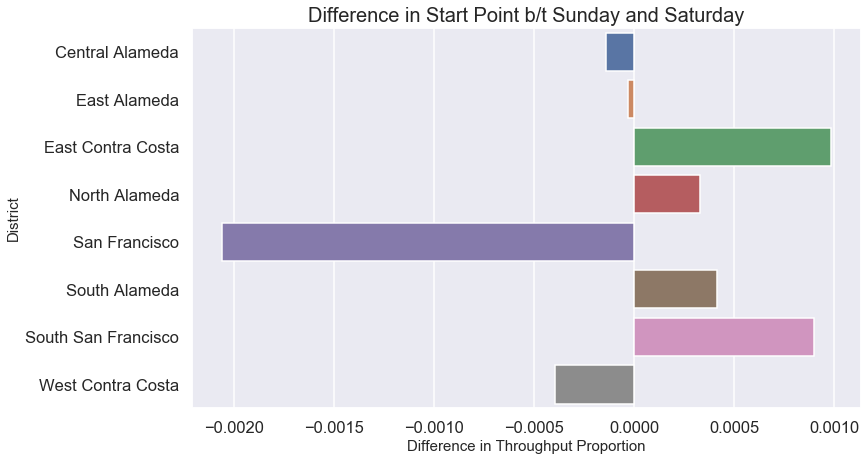

In [301]:
fig, axs = plt.subplots(figsize = (12, 7))
plt.title('Difference in Start Point b/t Sunday and Saturday', fontsize = 20)
sns.barplot(y = weekends.index, x = weekends['throughput'])
plt.ylabel('District', fontsize=15)
plt.xlabel("Difference in Throughput Proportion", fontsize=15)

Text(0.5, 0, 'Difference in Throughput Proportion')

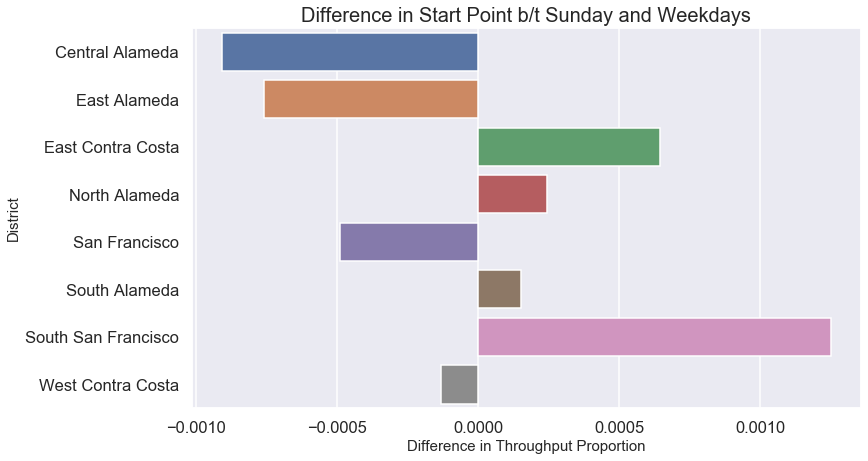

In [302]:
fig, axs = plt.subplots(figsize = (12, 7))
plt.title('Difference in Start Point b/t Sunday and Weekdays', fontsize = 20)
sns.barplot(y = weekend_weekday.index, x = weekend_weekday['throughput'])
plt.ylabel('District', fontsize=15)
plt.xlabel("Difference in Throughput Proportion", fontsize=15)

In [ ]:
morn_dest = jan_2018_morn.groupby('destination').sum()[['throughput']]

district_lst = []
for i in morn_dest.iterrows():
     district_lst.append(bart_district[i[0]])

morn_dest['district'] = district_lst
morn_dest;

In [ ]:
morn = morn_start.sort_values('throughput', ascending = False)
dest = morn_dest.sort_values('throughput', ascending = False) 

In [ ]:
fig, axs = plt.subplots(figsize = (15, 3))
sns.barplot(y = morn.index[:10], x = morn['throughput'][:10], hue = morn['district'][:10], dodge = False)
plt.title('Top Ten Stations Traffic Between 7am-10am [LEAVING]', fontsize = 20)

In [ ]:
fig, axs = plt.subplots(figsize = (15,3))
sns.barplot(y = dest.index[:10], x = dest['throughput'][:10], hue = dest['district'][:10], dodge = False)

In [ ]:
dest['throughput'][:10], dest.index[:10]

In [ ]:
# plt.ylabel('Conversion Rate', fontname="Arial", fontsize=15)
# plt.xlabel("Date", fontsize=15)
# plt.legend(prop = {'size': 14})
# plt.title('Conversion Rate by Day', fontsize = 20)

In [ ]:
# # will convert all of the destinations into its respective name
# station_dict = {}
# for i in station.iterrows():
#     station_dict[i[1]['Abbreviation']] = i[1]['Name'][:-7]

# station_func = np.vectorize(lambda x: station_dict[x])
# bart['start'] = station_func(np.array(bart['start']))
# bart['destination'] = station_func(np.array(bart['destination']))